<a href="https://colab.research.google.com/github/that-coding-kid/Malaria_Diagnosis_Model/blob/main/Malaria_Diagnosis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [98]:
import tensorflow_datasets as tfds

In [99]:
dataset, dataset_info = tfds.load("malaria", with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [100]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [101]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [102]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [103]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_dataset.take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = dataset.skip(int((VAL_RATIO+TRAIN_RATIO)*DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [104]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [105]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# **Dataset Visualization**

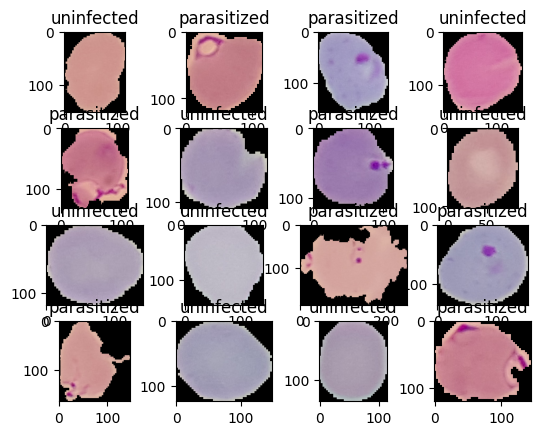

In [106]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax=plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))

In [107]:
dataset_info.features['label'].int2str(0)

'parasitized'

In [108]:
dataset_info.features['label'].int2str(1)

'uninfected'

# **Data Preprocessing**

First we resize our images into image of fixed height and width.

In [109]:
IM_SIZE=224

In [110]:
def resizing(image,label):
  return tf.image.resize(image, (IM_SIZE,IM_SIZE)), label

In [111]:
train_dataset=train_dataset.map(resizing)
val_dataset=val_dataset.map(resizing)
test_dataset=test_dataset.map(resizing)

In [112]:
for data, label in train_dataset.take(4):
  print(data)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32)
tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.

Next we apply normalization.

In [113]:
def normalization(image, label):
  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255.0, label

In [114]:
train_dataset=train_dataset.map(normalization)
val_dataset=val_dataset.map(normalization)
test_dataset=test_dataset.map(normalization)

In [115]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [116]:
train_dataset=train_dataset.shuffle(8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)


In [117]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [118]:
val_dataset=val_dataset.shuffle(8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [119]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [120]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# **Model Creation**

In [121]:
model=Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size =3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters = 16, kernel_size =3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="relu"),
    BatchNormalization(),
    Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [122]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics="accuracy"
              )

In [123]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 51s 70ms/step - loss: 0.3267 - accuracy: 0.8690 - val_loss: 0.9692 - val_accuracy: 0.5920
Epoch 2/20
689/689 [==============================] - 61s 89ms/step - loss: 0.2141 - accuracy: 0.9285 - val_loss: 0.1768 - val_accuracy: 0.9506
Epoch 3/20
689/689 [==============================] - 76s 110ms/step - loss: 0.1767 - accuracy: 0.9438 - val_loss: 0.1716 - val_accuracy: 0.9466
Epoch 4/20
689/689 [==============================] - 55s 80ms/step - loss: 0.1604 - accuracy: 0.9497 - val_loss: 0.2953 - val_accuracy: 0.9140
Epoch 5/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1491 - accuracy: 0.9516 - val_loss: 0.1755 - val_accuracy: 0.9459
Epoch 6/20
689/689 [==============================] - 52s 76ms/step - loss: 0.1288 - accuracy: 0.9584 - val_loss: 0.2677 - val_accuracy: 0.9372
Epoch 7/20
689/689 [==============================] - 47s 67ms/step - loss: 0.1220 - accuracy: 0.9596 - val_loss: 0.1904 - val_accuracy

In [124]:
test_dataset=test_dataset.batch(1)

In [125]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [126]:
model.evaluate(test_dataset)

2756/2756 [==============================] - 20s 3ms/step - loss: 0.4264 - accuracy: 0.9245


[0.4264408051967621, 0.9245283007621765]

In [127]:
def predict(p):
  if p>0.5:
    return str("U")
  else:
    return str("P")

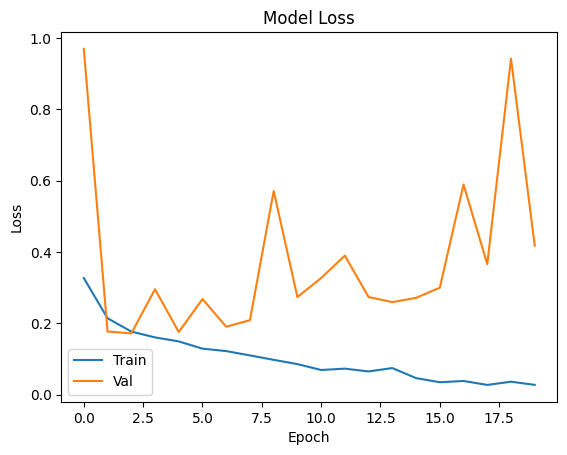

In [131]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"])
plt.show()

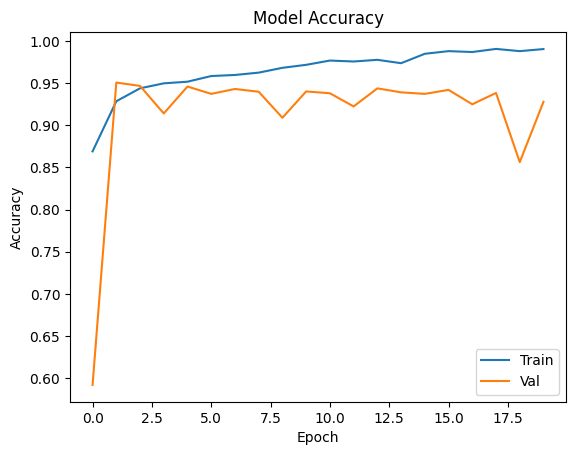

In [132]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"])
plt.show()

1/1 [==============================] - 0s 26ms/step


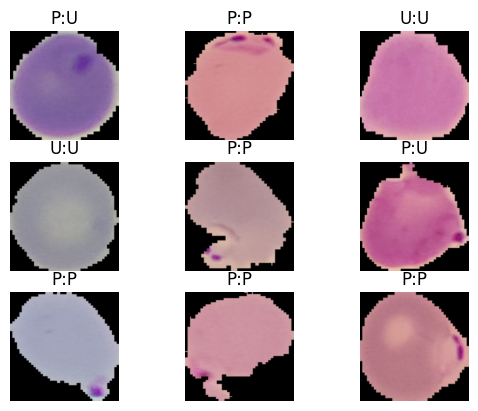

In [134]:
for i, (image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(predict(label.numpy()[0]))+":"+str(predict(model.predict(image)[0][0])))

  plt.axis('off')

In [139]:
drive.mount('/content/drive')

Mounted at /content/drive


In [141]:
!cp -r /content/covnet/ /content/drive/MyDrive/covnet_colab/

cp: cannot stat '/content/covnet/': No such file or directory
